### Embryo zebrafish development data: https://pubmed.ncbi.nlm.nih.gov/37468546/

In [6]:
import sys
import os
sys.path.append(os.path.abspath("../../src/utils"))
from preprocess import *  
from plotting import *
import pandas as pd
import matplotlib.pyplot as plt

data_dir = "../../data/embryo/raw/"
plot_dir = "../../data/embryo/plots/"
os.makedirs(plot_dir, exist_ok=True)

#### Load ATAC data and metadata

In [28]:
atac_data_path = os.path.join(data_dir, "atac_peak_matrix_complete_sparse.csv")
atac_data_df = pd.read_csv(atac_data_path)

meta_path = os.path.join(data_dir, "atac_all.metaData.txt")
atac_metadata_df = pd.read_csv(meta_path, index_col=0)


Map ATAC Cells: Assign each cell a pseudobulk, developmental stage + cell type using the authors' celltype assignment

In [29]:
atac_metadata_df = (
    atac_metadata_df
    [['celltype', 'predictedCell', 'predictedGroup']]
    .rename(columns={
        'celltype': 'atac_cell_type',
        'predictedCell': 'rna_matching_cell',
        'predictedGroup': 'rna_cell_type'
    })
    .reset_index(names="atac_cell")
)

def extract_stage(cell_id, delimiter='h', pos=0):
    return str(cell_id).split(delimiter)[pos].replace('h', '')

atac_metadata_df = atac_metadata_df.assign(
    rna_stage=lambda df: df['rna_matching_cell'].apply(extract_stage, args=('h', 0)),
    atac_stage=lambda df: df['atac_cell'].apply(extract_stage, args=('hpf', 0)),
    pseudobulk=lambda df: df['atac_stage'] + '_' + df['atac_cell_type']
)

atac_metadata_df.head()


,atac_cell,atac_cell_type,rna_matching_cell,rna_cell_type,rna_stage,atac_stage,pseudobulk
0,3hpf_1#3hpf_1_merge_BC0443_N27,blastomere,6h_3 CELL4645_N1 _,margin,6,3,3_blastomere
1,3hpf_1#3hpf_1_merge_BC0069_N07,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
2,3hpf_1#3hpf_1_merge_BC0033_N05,blastomere,3h1_CELL1337_N1_3h1,blastomere,3,3,3_blastomere
3,3hpf_1#3hpf_1_merge_BC0028_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere
4,3hpf_1#3hpf_1_merge_BC0264_N08,blastomere,3h1_CELL1197_N1_3h1,blastomere,3,3,3_blastomere


Aggregate accessibility signals from all cells in a pseudobulk (by pseudobulk mean)

In [30]:
atac_data_df = atac_data_df.merge(
    atac_metadata_df[['atac_cell', 'pseudobulk', 'atac_cell_type']],
    left_on='Cell', right_on='atac_cell', how='left'
)

# mean accessibility per pseudobulk
pseudobulk_matrix = (
    atac_data_df.groupby(['Peak', 'pseudobulk'])['Accessibility']
    .mean()  
    .unstack(fill_value=0)
)
# cell counts per pseudobulk
cell_counts = atac_data_df.groupby('pseudobulk')['Cell'].nunique().sort_values(ascending=False)


Boxplots: Distribution of total read count per cell in each pseudobulk - Colored by cell type
* Sorted by the most populated pseudobulks to the least
* Wider boxes might indicate either low quality cell type assignment **or** diverse chromatin accessibility behavior inside the pseudobulk (sub-categories)
* Narrow boxes indicate consistent pseudobulks --> more reliable especially on the right side of the plot (more cells)

/tmp/ipykernel_1427469/1836379902.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


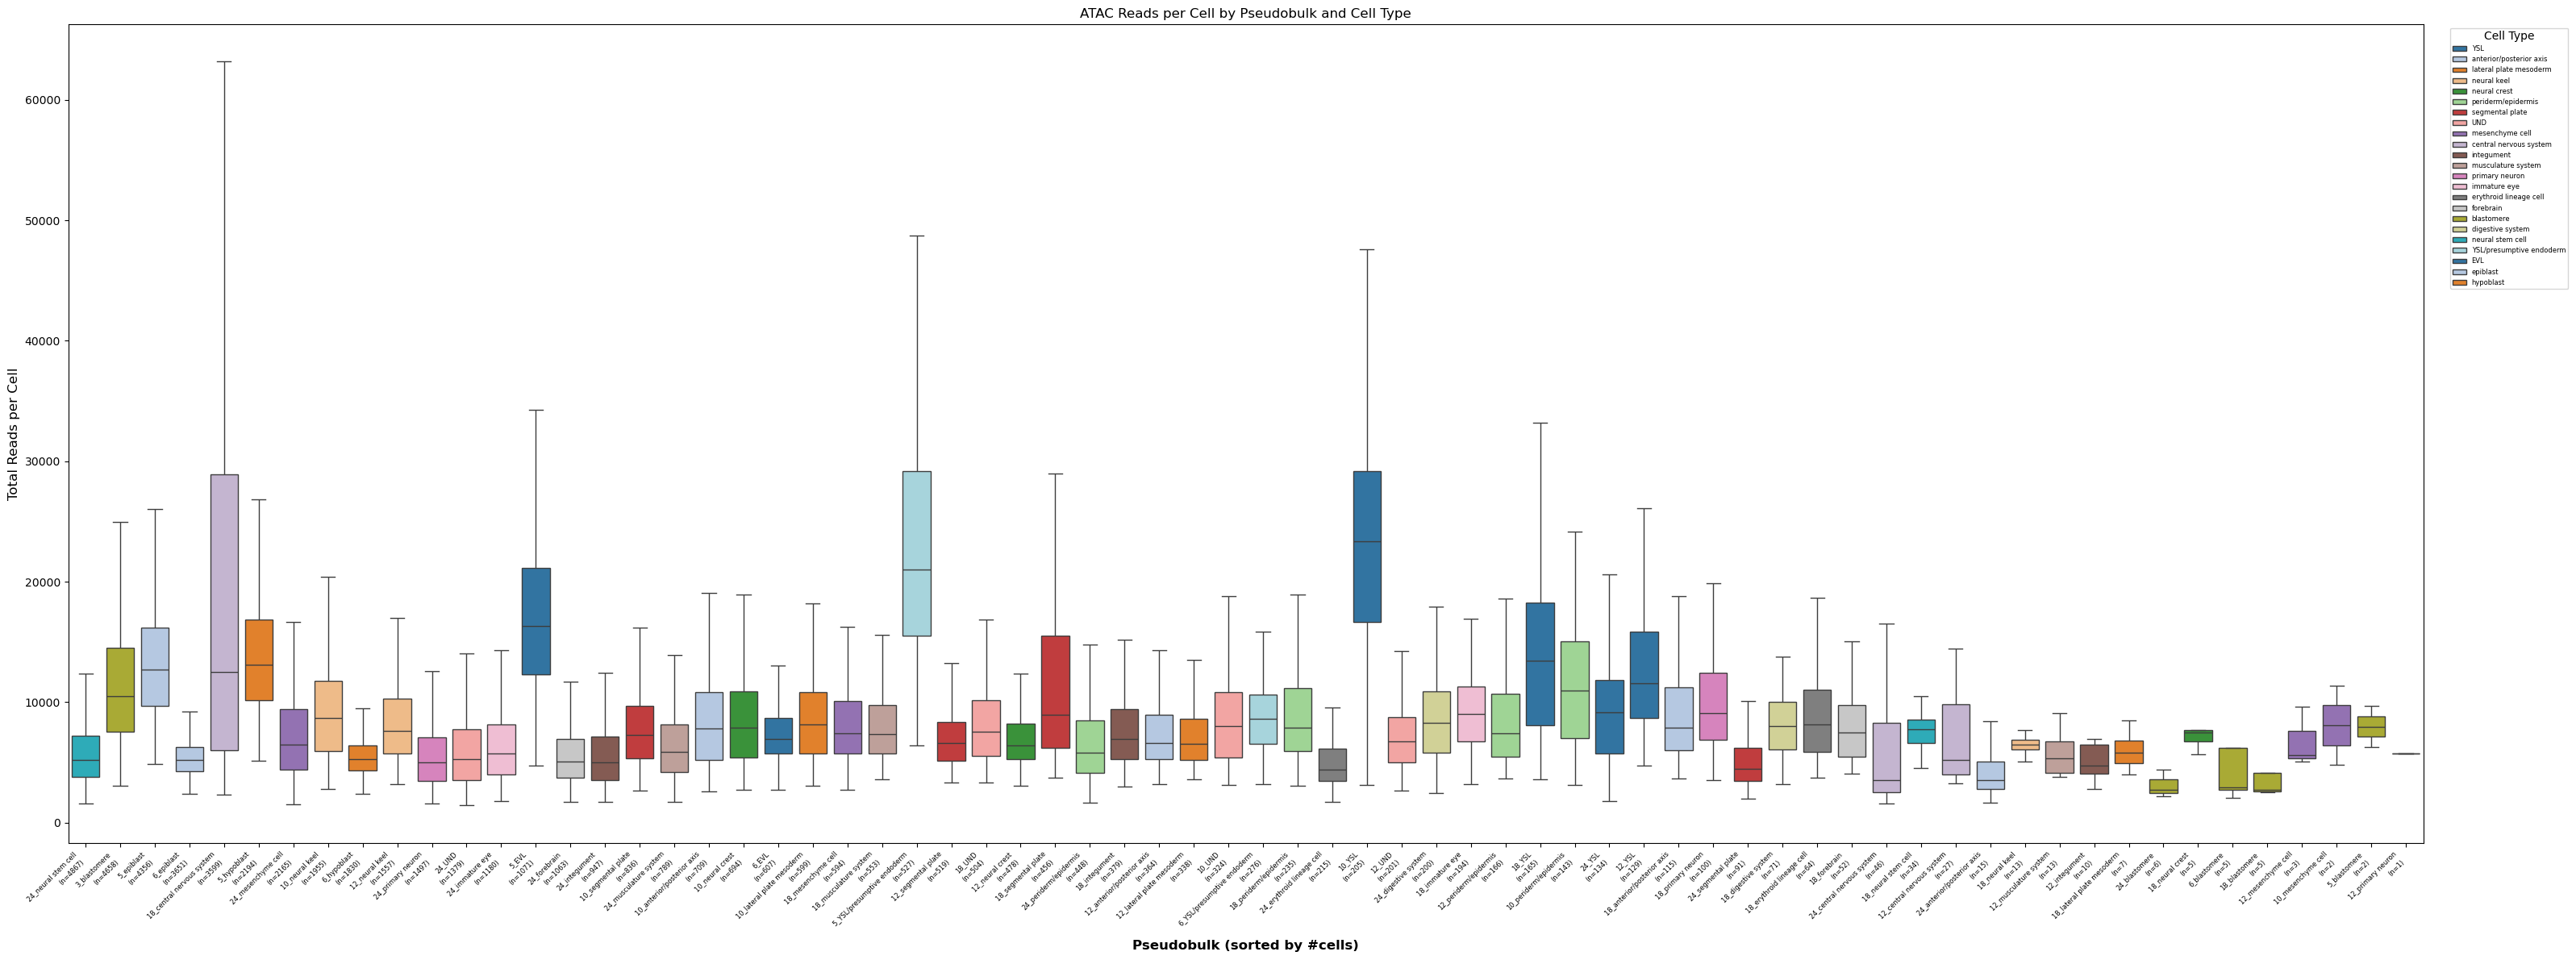

In [31]:
plot_pseudobulk_cell_read_distributions(atac_data_df, atac_metadata_df, save_path=plot_dir, show = True)

Scatterplots: Pseudobulk Cell Read Statistics vs Number of Cells

1. Median Reads per Cell: The mean depth of cells in each pseudobulk.
2. Standard Deviation (Std): The variability in total reads per cell within each pseudobulk.
3. Max-Min Range: The total reads per cell range in each pseudobulk.

Assists pseudobulking quality control.

There seems no clear trend between the pseuodbulk size and the variability of reads per cell --> suggests that the variability within pseudobulk is not due to small sample size.  
In that case we would expect the variabiility (figure 2 & 3) to decrease as the sample size increases. Thus heterogeneity could either derive from biological signal or cell missclassification.


 ❓Could this indicate that the cause of heterogeneity in some pseudobulks is biological signal? If not, is it safe to discard heterogenious pseudobulks?



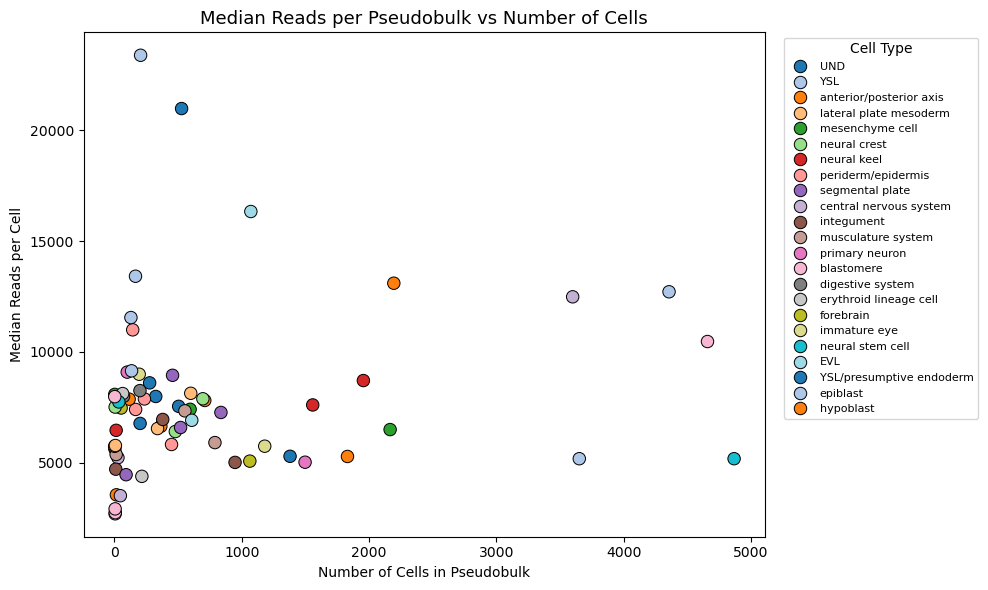

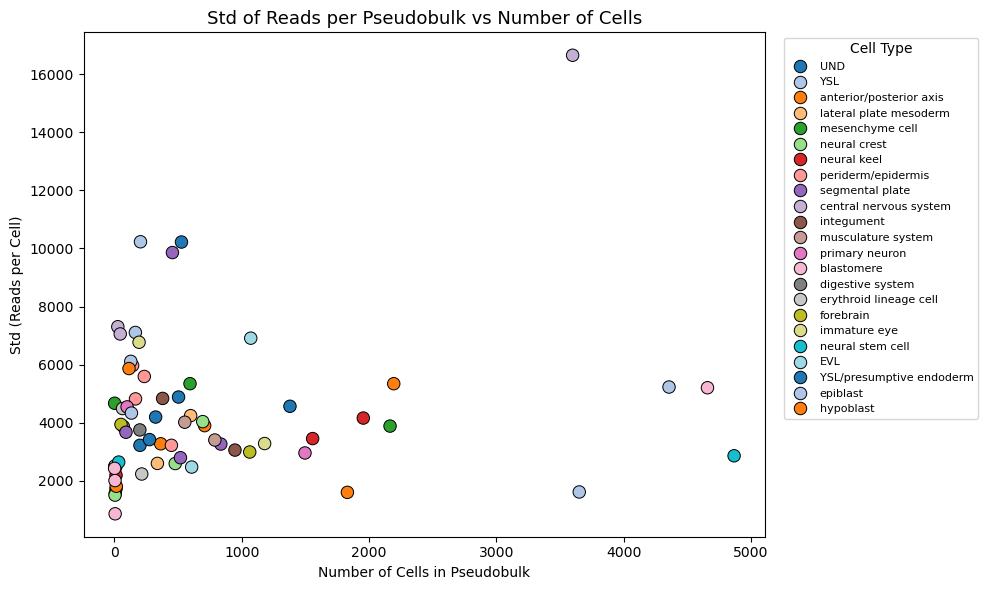

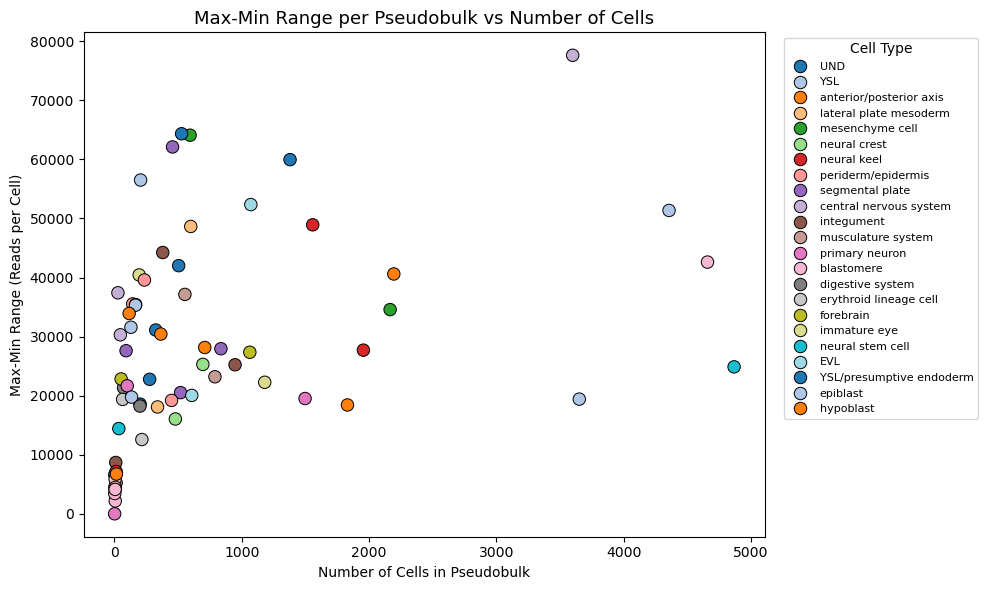

In [32]:
plot_pseudobulk_agg_stats(atac_data_df, atac_metadata_df, save_path=plot_dir, show=True)

### Plasticity

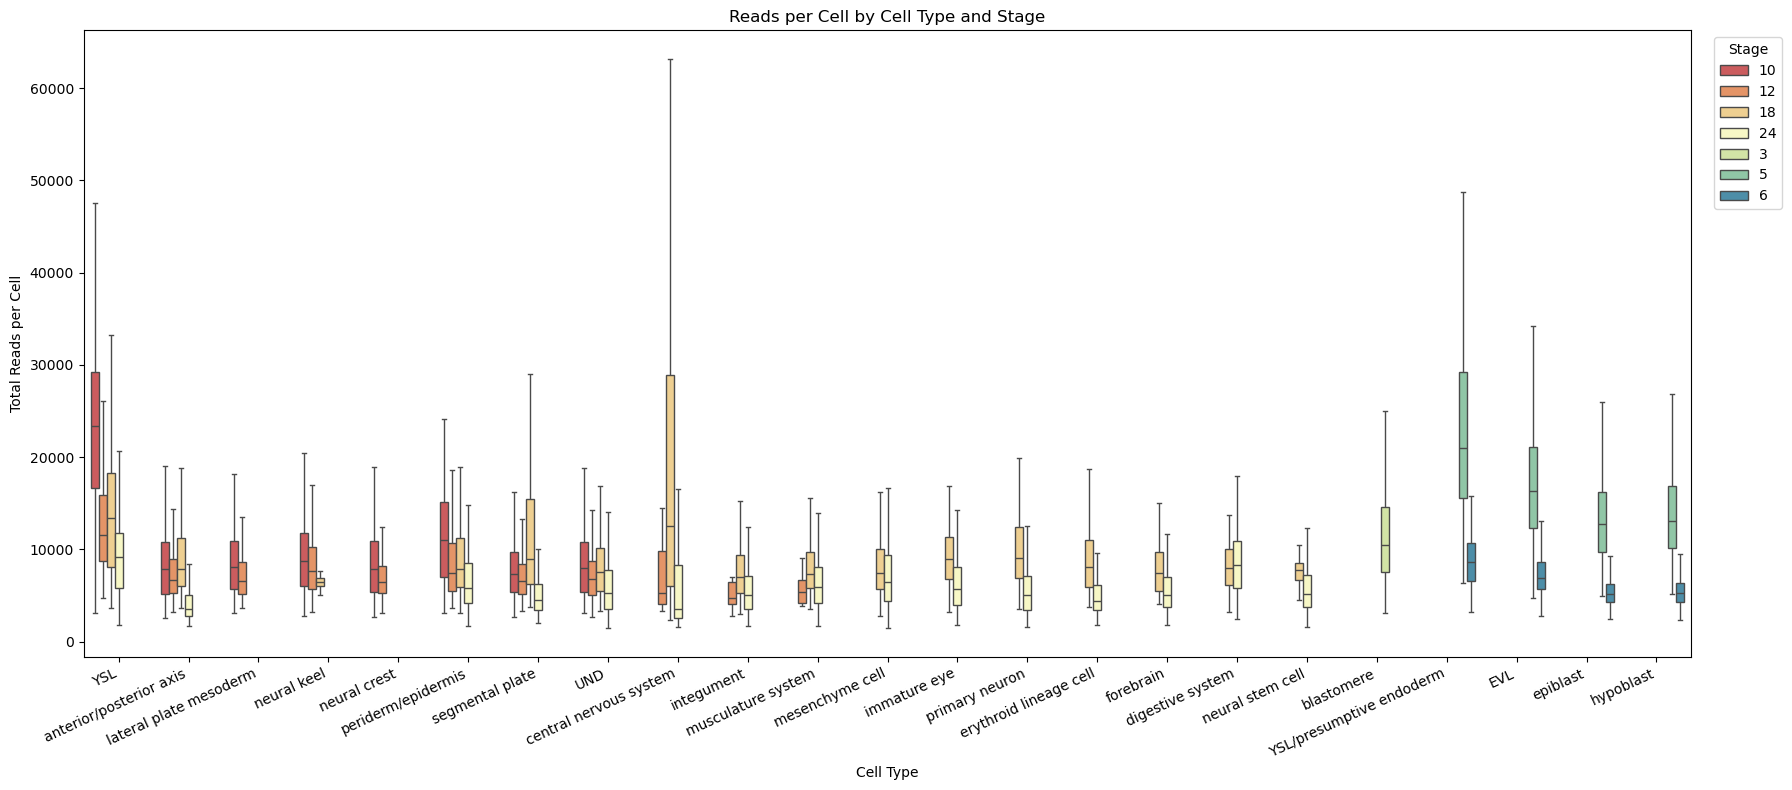

In [ ]:

plot_reads_per_cell_by_celltype_and_stage(
    total_per_cell,
    atac_metadata_df,
    min_cells_per_group=10,
    figsize=(18, 8),data/embryo/plots/reads_per_cell_by_celltype_and_stage.png
    save_path = '../../data/embryo/plots/reads_per_cell_by_celltype_and_stage.png',
    show=True)

In [91]:

def plot_reads_per_cell_by_celltype_and_stage(
    total_per_cell,
    atac_metadata_df,
    min_cells_per_group=10,
    figsize=(18, 8),
    save_path=None,
    show=True
):
    df_reads = (
        total_per_cell.rename_axis('Cell').reset_index()
        .merge(atac_metadata_df, left_on='Cell', right_on='atac_cell', how='left')
        .dropna(subset=['atac_cell_type', 'atac_stage'])
    )
    # Filter to groups with enough cells
    ct_stage_counts = df_reads.groupby(['atac_cell_type', 'atac_stage']).size().reset_index(name='count')
    good = ct_stage_counts[ct_stage_counts['count'] >= min_cells_per_group]
    df_reads = df_reads.merge(
        good[['atac_cell_type', 'atac_stage']],
        on=['atac_cell_type', 'atac_stage'],
        how='inner'
    )

    plt.figure(figsize=figsize)
    sns.boxplot(
        data=df_reads,
        x='atac_cell_type',
        y='Accessibility',
        hue='atac_stage',
        showfliers=False,
        palette='Spectral'
    )
    plt.xlabel('Cell Type')
    plt.ylabel('Total Reads per Cell')
    plt.title('Reads per Cell by Cell Type and Stage')
    plt.legend(title='Stage', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    if show:
        plt.show()
    else:
        plt.close()
